In [48]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from skimage.measure import block_reduce
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
in_dir = 'dataset2-master/dataset2-master/images'

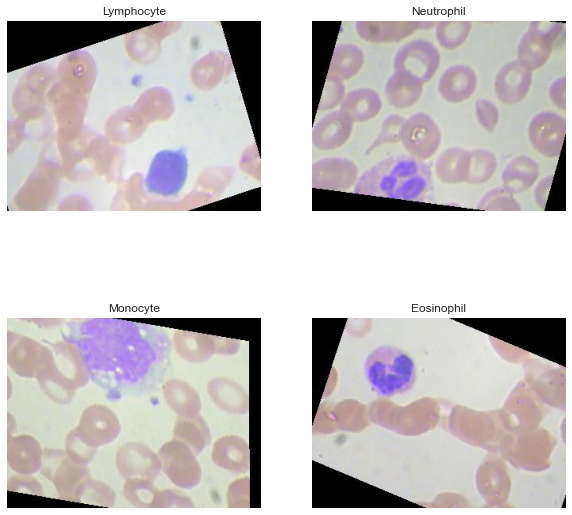

<Figure size 864x576 with 0 Axes>

In [23]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
def plotImage(h,w,image_path,title):
    image = cv2.imread(image_path)  # BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # RGB
    axes[w,h].imshow(image)
    axes[w,h].axis('off')
    axes[w,h].set_title(title)
    
plt.figure(figsize=(12,8))
lymp_path = os.path.join(in_dir, 'TRAIN/LYMPHOCYTE') 
mono_path = os.path.join(in_dir, 'TRAIN/MONOCYTE')
neu_path = os.path.join(in_dir, 'TRAIN/NEUTROPHIL')
eos_path = os.path.join(in_dir, 'TRAIN/EOSINOPHIL')
plotImage(0,0,os.path.join(lymp_path, random.choice(os.listdir(lymp_path))),'Lymphocyte')
plotImage(0,1,os.path.join(mono_path, random.choice(os.listdir(mono_path))),'Monocyte')
plotImage(1,0,os.path.join(neu_path, random.choice(os.listdir(neu_path))),'Neutrophil')
plotImage(1,1,os.path.join(eos_path, random.choice(os.listdir(eos_path))),'Eosinophil')
plt.tight_layout()
plt.show()

Total Train samples: 9957

Total Test samples: 2487



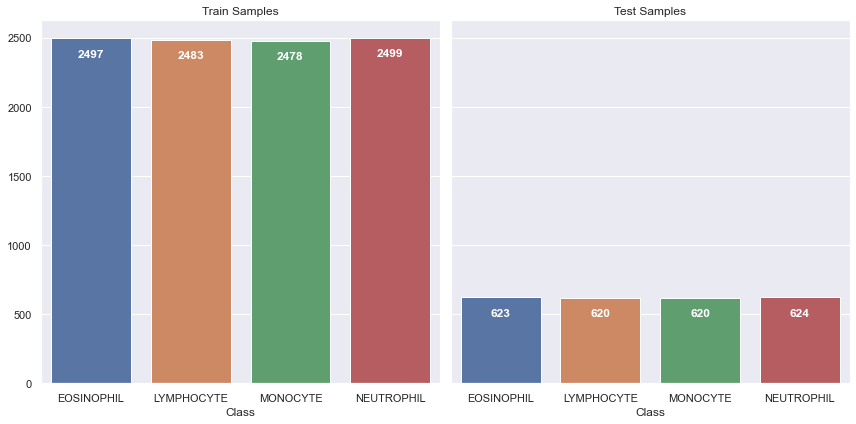

In [24]:
train_dir = os.path.join(in_dir, "TRAIN")
test_dir = os.path.join(in_dir, "TEST")
num_samples = 0
def plot_num_samples(path, s, ax):
    x = []
    y = []
    num_samples = 0
    for cls in os.listdir(path):
        num_imgs = len(os.listdir(os.path.join(path, cls)))
        num_samples += num_imgs
        x.append(cls)
        y.append(num_imgs)

    print('Total ' + s + ' samples: {:d}\n'.format(num_samples))
    sns.barplot(x=x, y=y, ax=ax)
    ax.set_xlabel('Class')
    ax.set_title(s + ' Samples')
    for index, value in enumerate(y):
        ax.text(index, value-150, str(value), ha='center', va='bottom', color='white',weight='bold', fontsize=12)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
plot_num_samples(train_dir, "Train", ax1)
plot_num_samples(test_dir, "Test", ax2)
plt.tight_layout()
plt.show()

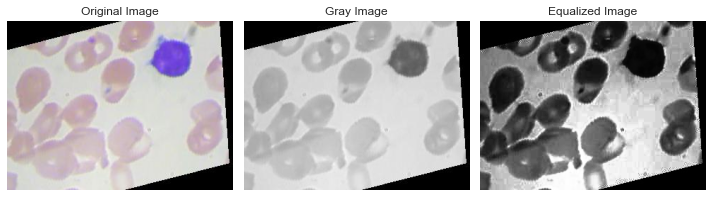

In [25]:
random_file = random.choice(os.listdir(lymp_path))
image = cv2.imread(os.path.join(lymp_path, random_file), cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(os.path.join(lymp_path, random_file))
image2 = image2[:, :, [2, 1, 0]]


# Perform histogram equalization
equalized_image = cv2.equalizeHist(image)
# Display the original and equalized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(image2)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')
plt.title('Gray Image')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(equalized_image, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')


plt.tight_layout()
plt.show()

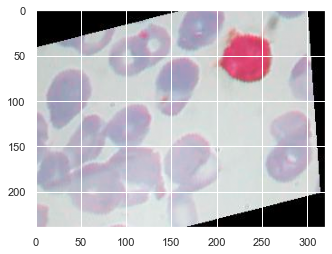

In [26]:
image3 = cv2.imread(os.path.join(lymp_path, random_file))
image3 = np.array(image3)
image3 = image3.astype(float) / 255

plt.imshow(image3)

In [27]:
def read_resize_img(path):
    image = cv2.imread(path)  # BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # RGB
    resized_image = cv2.resize(image, (160,120))
    return resized_image

In [28]:
def create_sub_df(directory_path,num_cls):
    images = np.ndarray((len(os.listdir(directory_path)),120*160*3), dtype=np.uint8)
    i=0
    for file_name in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file_name)
        resized_image = read_resize_img(file_path)
        images[i,:] = resized_image.ravel()
        i+=1
    df = pd.DataFrame(images)
    df["target"] = num_cls
    return df

def create_df(directory_path):
    clss = []
    for cls in os.listdir(directory_path):
        if str(cls) == "MONOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),0))
        elif str(cls) == "LYMPHOCYTE":
            clss.append(create_sub_df(os.path.join(directory_path, cls),1))
        elif str(cls) == "NEUTROPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),2))
        elif str(cls) == "EOSINOPHIL":
            clss.append(create_sub_df(os.path.join(directory_path, cls),3))
    df = pd.concat(clss)
    return shuffle(df).reset_index(drop=True)

In [29]:
df_train = create_df(train_dir)
df_test = create_df(test_dir)

In [30]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,57591,57592,57593,57594,57595,57596,57597,57598,57599,target
0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,4,0,0,4,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,220,218,206,217,213,201,192,186,174,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,95,85,83,93,82,79,94,86,84,47,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
9953,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9955,0,0,0,0,0,0,0,0,0,0,...,4,4,6,6,6,7,5,5,5,1


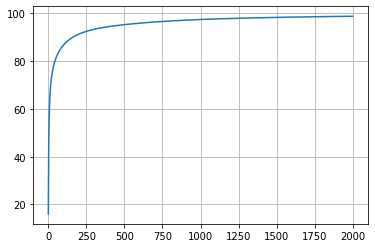

In [75]:
pca = PCA(n_components=2000)
pca.fit(df_train)
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.savefig('pca.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


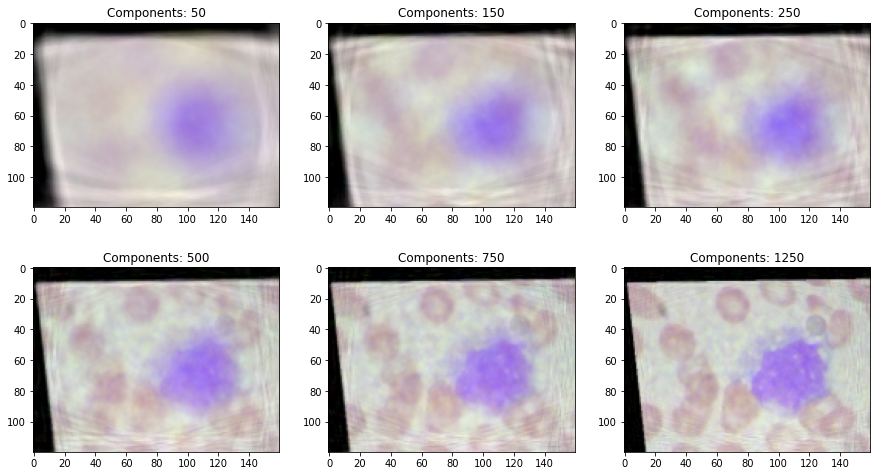

In [69]:
def plot_at_k(k):
    pca = PCA(n_components=k)
    x = mono_train.iloc[:, :-1]
#     print(np.array(x.iloc[2, :]))
    x = x.astype(float) / 255
    x = pca.fit_transform(x)         
    dff = pd.DataFrame(pca.inverse_transform(x))
#     print(np.array(dff.iloc[2, :]))
    plt.imshow(np.array(dff.iloc[2, :]).reshape((120, 160, 3)))


ks = [50, 150, 250,500,750,1250]

plt.figure(figsize=[15, 9])

for i in range(6):
    plt.subplot(2, 3, i+1)
    plot_at_k(ks[i])
    plt.title("Components: " + str(ks[i]))

plt.subplots_adjust(wspace=0.2, hspace=0.0)
plt.show()
# first_row

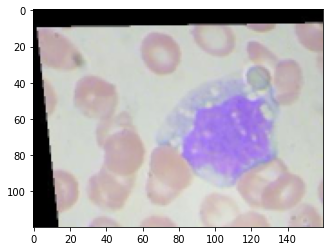

In [140]:
plt.imshow(np.array(mono_train.iloc[2, :-1]).reshape((120, 160, 3)))


In [110]:
pca = PCA(n_components=2000)
df_train_reconstructed_pca = pca.inverse_transform(pca.fit_transform(df_train.iloc[:, :-1]))
df_test_reconstructed_pca = pca.inverse_transform(pca.transform(df_test.iloc[:, :-1]))

In [114]:
df_train_reconstructed_pca = pd.DataFrame(df_train_reconstructed_pca)
df_test_reconstructed_pca = pd.DataFrame(df_test_reconstructed_pca)

In [121]:
def max_pooling(df):
    max_pool_df = pd.DataFrame()  # Empty DataFrame to store pooled images
    for i in range(len(df)):
        img = df.values[i].reshape(120, 160, 3)
        max_pool = block_reduce(img, block_size=(5, 5, 1), func=np.max)
        ravel_img = max_pool.ravel()

        # Append pooled image as a row to max_pool_df
        max_pool_df = max_pool_df.append(pd.Series(ravel_img), ignore_index=True)
        
    return max_pool_df
    

In [71]:
max_m = max_pooling(mono_train).astype('uint8')
max_l = max_pooling(lymp_train).astype('uint8')

(-0.5, 31.5, 23.5, -0.5)

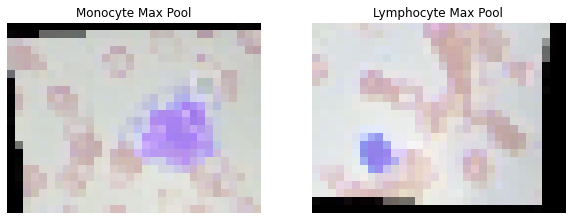

In [74]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.array(max_m.iloc[2, :-1]).reshape(24, 32, 3))
plt.title('Monocyte Max Pool')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.array(max_l.iloc[2, :-1]).reshape(24, 32, 3))
plt.title('Lymphocyte Max Pool')
plt.axis('off')

In [122]:
df_train_max_poll = max_pooling(pd.DataFrame(df_train_reconstructed_pca))
df_test_max_poll = max_pooling(pd.DataFrame(df_test_reconstructed_pca))

Text(0.5, 1.0, '1.8601804555905268')

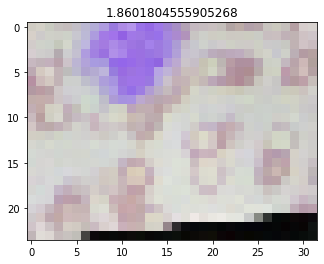

In [88]:
img = df_train_max_poll.iloc[2, :-1] / 255

plt.imshow(np.array(img).reshape(24, 32, 3))
plt.title(df_train_max_poll.iloc[2, -1])

In [124]:
df_train_max_poll = df_train_max_poll.join(df_train.iloc[:, -1])
df_test_max_poll = df_test_max_poll.join(df_test.iloc[:, -1])

In [126]:
df_train_max_poll.to_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/train_pca_mpool.csv', index=False)
df_test_max_poll.to_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/test_pca_mpool.csv', index=False)

In [2]:
df_train_max_poll = pd.read_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/train_pca_mpool.csv')
df_test_max_poll = pd.read_csv('C:/Users/נעמיה/OneDrive - Ariel University/ML project/test_pca_mpool.csv')

# Models


In [3]:
X_train, y_train = df_train_max_poll.iloc[:, :-1], df_train_max_poll.iloc[:, -1]
X_test, y_test = df_test_max_poll.iloc[:, :-1], df_test_max_poll.iloc[:, -1]

In [4]:
df_train_max_poll

,0,1,2,3,4,5,6,7,8,9,...,2295,2296,2297,2298,2299,2300,2301,2302,2303,target
0,213.927856,201.505630,199.785072,212.042538,194.290631,193.201697,200.104004,183.243434,181.337762,185.608974,...,24.708316,27.876630,28.384156,14.475192,12.630548,13.405411,10.311603,10.544174,9.762943,2
1,10.451947,10.648147,7.460923,173.530462,167.593483,168.836917,224.313858,221.010827,217.026901,206.469831,...,7.771059,9.649631,5.458064,6.655407,11.012748,9.245616,17.676291,21.470518,20.570924,3
2,209.914682,203.937682,196.559067,211.365483,209.542925,202.451368,208.412971,207.055897,200.765399,201.400440,...,6.004455,8.888206,10.650558,9.667785,12.010202,10.787807,10.248925,13.565562,12.594568,1
3,15.778543,18.198164,13.247783,5.143325,10.382363,7.297202,4.248349,12.164793,6.020629,18.496854,...,207.203325,207.189738,200.061212,188.729350,187.138494,183.438974,120.202385,118.914883,121.364772,2
4,9.981002,10.961536,8.923553,6.184986,6.332098,5.063374,10.967024,14.872974,11.862715,6.048618,...,226.203549,224.357756,228.363317,225.266482,225.628721,218.243441,225.350551,226.073236,215.124520,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,7.094290,6.475522,10.865129,10.446786,9.697138,14.847230,7.334858,7.793813,11.380058,11.389491,...,211.207263,210.508903,201.893906,203.609963,204.845827,198.486105,194.398412,188.353700,189.093345,3
9953,7.916909,5.997268,5.868418,12.347532,10.961828,7.180793,8.188294,5.394987,5.390001,6.772056,...,6.350224,10.645470,7.519439,7.753761,11.707059,14.086170,5.419818,7.025313,10.466441,1
9954,12.049410,6.607852,11.028860,10.461475,6.831324,7.480618,9.330502,7.255613,6.529084,7.281557,...,7.181734,7.858839,10.645139,5.409923,7.737677,9.058065,3.746487,5.740539,8.430655,2
9955,195.493124,194.899229,193.138593,202.047728,200.941293,203.842019,199.723568,195.280348,191.257244,200.760202,...,105.194533,96.835362,98.578402,7.961119,5.624381,5.508895,7.000309,3.313445,3.989799,4


In [5]:
k_range = list(range(1, 14, 2))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

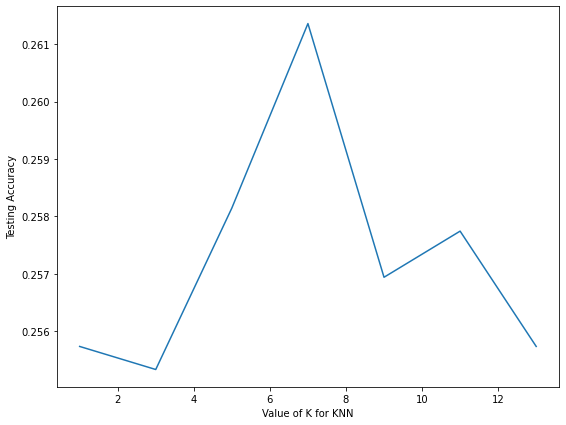

In [6]:
plt.subplots(figsize=(9, 7))
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

Training Accuracy : 0.49201566736968966
Testing Accuracy : 0.26135906714917573

              precision    recall  f1-score   support

           1       0.26      0.35      0.30       620
           2       0.28      0.19      0.22       620
           3       0.27      0.33      0.30       624
           4       0.23      0.17      0.19       623

    accuracy                           0.26      2487
   macro avg       0.26      0.26      0.25      2487
weighted avg       0.26      0.26      0.25      2487



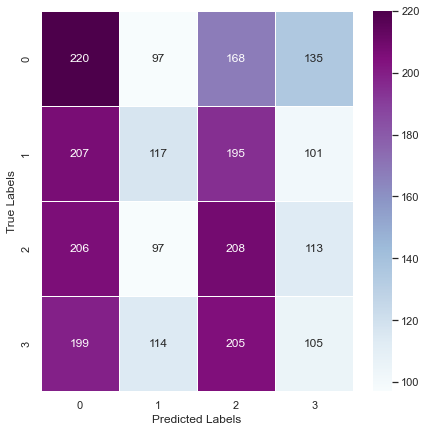

In [7]:
results={}

def HetmapAndConf(model , X_train , y_train , X_test, y_test):
    #training the model
    model.fit(X_train,y_train)
    #model prediction
    y_pred = model.predict(X_test)
    sns.set(font_scale=1)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=True , cmap="BuPu", linewidths=1, fmt = 'd')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    # add accuracy score to 'results'
    results[model]=metrics.accuracy_score(y_test, y_pred)
    # evaluating the model
    print("Training Accuracy :", model.score(X_train, y_train))
    print("Testing Accuracy :" , metrics.accuracy_score(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))
HetmapAndConf(KNeighborsClassifier(n_neighbors=7) , X_train , y_train , X_test, y_test)

In [9]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy : 0.7025208396103244
Testing Accuracy : 0.39525532770406113

              precision    recall  f1-score   support

           1       0.53      0.58      0.55       620
           2       0.44      0.34      0.38       620
           3       0.31      0.35      0.33       624
           4       0.31      0.31      0.31       623

    accuracy                           0.40      2487
   macro avg       0.40      0.40      0.39      2487
weighted avg       0.40      0.40      0.39      2487



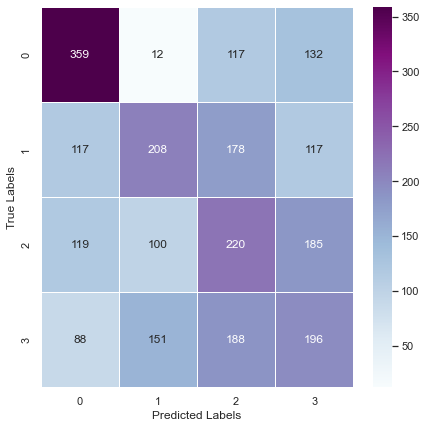

In [18]:
HetmapAndConf(LogisticRegression(max_iter=200) , X_train_std , y_train , X_test_std, y_test)

In [33]:
X_train_s, y_train_s = df_train.iloc[:, :-1], df_train.iloc[:, -1]
X_test_s, y_test_s = df_test.iloc[:, :-1], df_test.iloc[:, -1]
X_test_s, X_val, y_test_s, y_val = train_test_split(X_test_s, y_test_s, test_size = 0.5)

In [36]:
reshaped_X_train = X_train_s.to_numpy().reshape((9957, 120, 160, 3))
reshaped_X_test = X_test_s.to_numpy().reshape((1243, 120, 160, 3))
reshaped_X_val = X_val.to_numpy().reshape((1244, 120, 160, 3))

In [38]:
reshaped_X_train_s = reshaped_X_train_s / 255.0 
reshaped_X_val = reshaped_X_val / 255.0
reshaped_X_test_s = reshaped_X_test_s / 255.0

In [56]:
model1 = Sequential()

# First Conv Layer
model1.add(Conv2D(16 , (3,3) , activation = 'relu' , input_shape = (120,160,3)))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv Layer
model1.add(Conv2D(32, (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

# Third Conv Layer
model1.add(Conv2D(64, (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

# FC layer
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.25))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# Train
history1 = model1.fit(
    reshaped_X_train_s, 
    y_train_s, 
    batch_size = 32, 
    epochs = 50, 
    validation_data=(reshaped_X_val, y_val),
    callbacks=[early_stopping]
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 118, 158, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 59, 79, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 57, 77, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 38, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 28, 38, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 36, 64)       

In [59]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(11)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'b-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

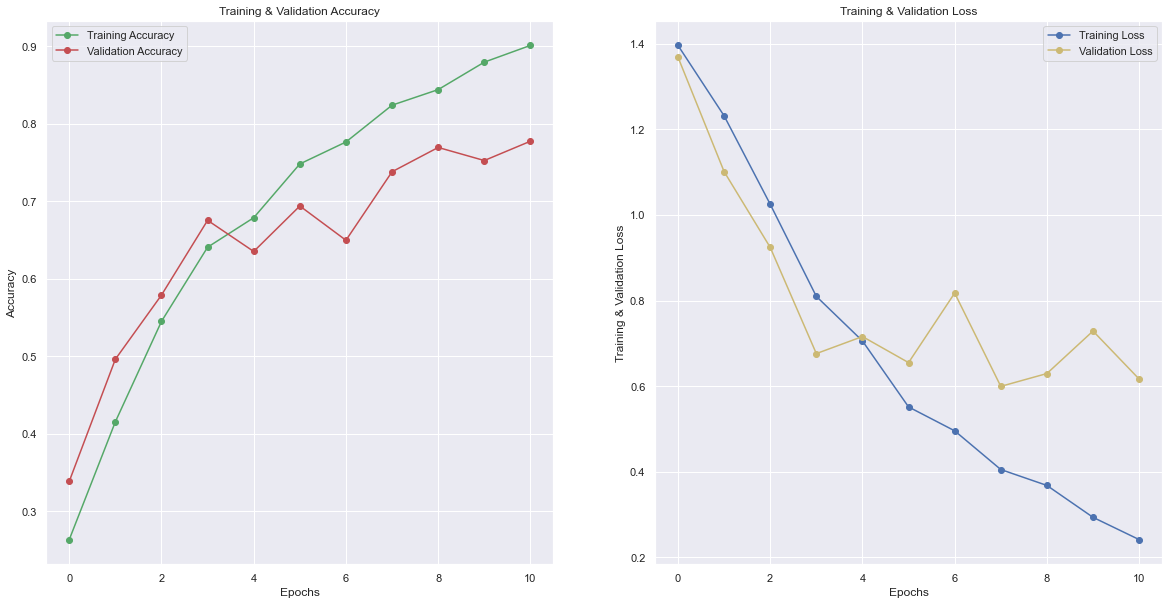

In [60]:
plot_accuracy_loss_chart(history1)


In [61]:
results = model1.evaluate(reshaped_X_test_s, y_test_s)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")

39/39 [==============================] - 4s 110ms/step - loss: 0.5940 - accuracy: 0.7836
Loss of the model  is - test  0.5940081477165222
Accuracy of the model is - test 78.35881114006042 %
